In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import math

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Hyperparameters
T = 1000  # Total timesteps
batch_size = 128
lr = 1e-4
num_epochs = 50

# MNIST dataset and dataloader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [ ]:
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

100%|█████████████████████████████████████████████████████████████████| 26421880/26421880 [00:04<00:00, 5512305.81it/s]


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|████████████████████████████████████████████████████████████████████████| 29515/29515 [00:00<00:00, 173508.55it/s]


Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



100%|███████████████████████████████████████████████████████████████████| 4422102/4422102 [00:01<00:00, 2996110.88it/s]


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████████████████████████████████████████████████████████████████████████████████| 5148/5148 [00:00<?, ?it/s]

Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



In [ ]:
# Noise schedule
beta_start = 1e-4
beta_end = 0.02
beta = torch.linspace(beta_start, beta_end, T, device=device)
alpha = 1. - beta
alpha_bar = torch.cumprod(alpha, dim=0)

In [ ]:
# Timestep embedding
def timestep_embedding(t, dim):
    half_dim = dim // 2
    emb = torch.log(torch.tensor(10000.0)) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, dtype=torch.float32) * -emb)
    emb = emb.to(t.device)
    emb = t.float()[:, None] * emb[None, :]
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
    return emb

class AdaptiveGroupNorm(nn.Module):
    def __init__(self, num_groups, embed_dim):
        super().__init__()
        self.norm = nn.GroupNorm(num_groups, num_groups)
        self.proj = nn.Linear(embed_dim, num_groups * 2)

    def forward(self, x, t_emb):
        # t_emb: (batch, embed_dim)
        scale, shift = torch.chunk(self.proj(t_emb), 2, dim=1)
        x = self.norm(x)
        x = x * (scale[:, :, None, None] + 1) + shift[:, :, None, None]
        return x

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, embed_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.norm1 = AdaptiveGroupNorm(out_channels, embed_dim)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.norm2 = AdaptiveGroupNorm(out_channels, embed_dim)
        self.act = nn.SiLU()

    def forward(self, x, t_emb):
        x = self.conv1(x)
        x = self.norm1(x, t_emb)
        x = self.act(x)
        x = self.conv2(x)
        x = self.norm2(x, t_emb)
        x = self.act(x)
        return x

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        embed_dim = 64

        # Time embedding
        self.time_embed = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.SiLU(),
            nn.Linear(embed_dim, embed_dim)
        )

        # Encoder
        self.enc_conv1 = ConvBlock(1, 64, embed_dim)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.enc_conv2 = ConvBlock(64, 128, embed_dim)
        self.pool2 = nn.MaxPool2d(2, 2)

        # Middle
        self.mid_conv1 = nn.Conv2d(128, 256, 3, padding=1)
        self.mid_conv2 = nn.Conv2d(256, 256, 3, padding=1)

        # Decoder
        self.upconv1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec_conv1 = ConvBlock(256, 128, embed_dim)  # 128*2 after cat

        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec_conv2 = ConvBlock(128, 64, embed_dim)   # 64*2 after cat

        # Output
        self.final_conv = nn.Conv2d(64, 1, kernel_size=3, padding=1)

    def forward(self, x, t):
        # Time embedding
        t_emb = timestep_embedding(t, 64)
        t_emb = self.time_embed(t_emb)

        # Encoder
        e1 = self.enc_conv1(x, t_emb)
        p1 = self.pool1(e1)

        e2 = self.enc_conv2(p1, t_emb)
        p2 = self.pool2(e2)

        # Middle
        x = self.mid_conv1(p2)
        x = F.silu(x)
        x = self.mid_conv2(x)
        x = F.silu(x)

        # Decoder
        d1 = self.upconv1(x)
        d1 = torch.cat([e2, d1], dim=1)
        d1 = self.dec_conv1(d1, t_emb)

        d0 = self.upconv2(d1)
        d0 = torch.cat([e1, d0], dim=1)
        d0 = self.dec_conv2(d0, t_emb)

        return self.final_conv(d0)

In [ ]:
# Initialize model and optimizer
model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
# Training loop
for epoch in range(num_epochs):
    for batch_idx, (x0, _) in enumerate(train_loader):
        x0 = x0.to(device)

        # Random timesteps and noise
        t = torch.randint(0, T, (x0.shape[0],), device=device)
        noise = torch.randn_like(x0)

        # Forward process
        sqrt_alpha_bar = torch.sqrt(alpha_bar[t])[:, None, None, None]
        sqrt_one_minus_alpha_bar = torch.sqrt(1 - alpha_bar[t])[:, None, None, None]
        x_t = sqrt_alpha_bar * x0 + sqrt_one_minus_alpha_bar * noise

        # Predict noise
        pred_noise = model(x_t, t)

        # Loss and backprop
        loss = F.mse_loss(pred_noise, noise)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs} Loss: {loss.item():.4f}")

Epoch 1/50 Loss: 0.0591
Epoch 2/50 Loss: 0.0564
Epoch 3/50 Loss: 0.0483
Epoch 4/50 Loss: 0.0612
Epoch 5/50 Loss: 0.0385
Epoch 6/50 Loss: 0.0488
Epoch 7/50 Loss: 0.0615
Epoch 8/50 Loss: 0.0455
Epoch 9/50 Loss: 0.0415
Epoch 10/50 Loss: 0.0473
Epoch 11/50 Loss: 0.0548
Epoch 12/50 Loss: 0.0330
Epoch 13/50 Loss: 0.0357
Epoch 14/50 Loss: 0.0449
Epoch 15/50 Loss: 0.0443
Epoch 16/50 Loss: 0.0440
Epoch 17/50 Loss: 0.0499
Epoch 18/50 Loss: 0.0410
Epoch 19/50 Loss: 0.0419
Epoch 20/50 Loss: 0.0362
Epoch 21/50 Loss: 0.0361
Epoch 22/50 Loss: 0.0455
Epoch 23/50 Loss: 0.0523
Epoch 24/50 Loss: 0.0444
Epoch 25/50 Loss: 0.0311
Epoch 26/50 Loss: 0.0454
Epoch 27/50 Loss: 0.0401
Epoch 28/50 Loss: 0.0406
Epoch 29/50 Loss: 0.0395
Epoch 30/50 Loss: 0.0483
Epoch 31/50 Loss: 0.0338
Epoch 32/50 Loss: 0.0333
Epoch 33/50 Loss: 0.0367
Epoch 34/50 Loss: 0.0335
Epoch 35/50 Loss: 0.0513
Epoch 36/50 Loss: 0.0423
Epoch 37/50 Loss: 0.0304
Epoch 38/50 Loss: 0.0373
Epoch 39/50 Loss: 0.0396
Epoch 40/50 Loss: 0.0578
Epoch 41/

In [ ]:
# Sampling function
@torch.no_grad()
def sample(model, batch_size=16):
    model.eval()
    x = torch.randn((batch_size, 1, 28, 28), device=device)

    for t in reversed(range(T)):
        t_tensor = torch.full((batch_size,), t, device=device, dtype=torch.long)
        pred_noise = model(x, t_tensor)

        alpha_t = alpha[t]
        alpha_bar_t = alpha_bar[t]
        beta_t = beta[t]

        if t > 0:
            noise = torch.randn_like(x)
        else:
            noise = torch.zeros_like(x)

        x = (x - (beta_t / torch.sqrt(1 - alpha_bar_t)) * pred_noise) / torch.sqrt(alpha_t)
        x += torch.sqrt(beta_t) * noise

    x = torch.clamp(x, -1.0, 1.0)
    return x

In [ ]:
# Generate samples
samples = sample(model, batch_size=64)

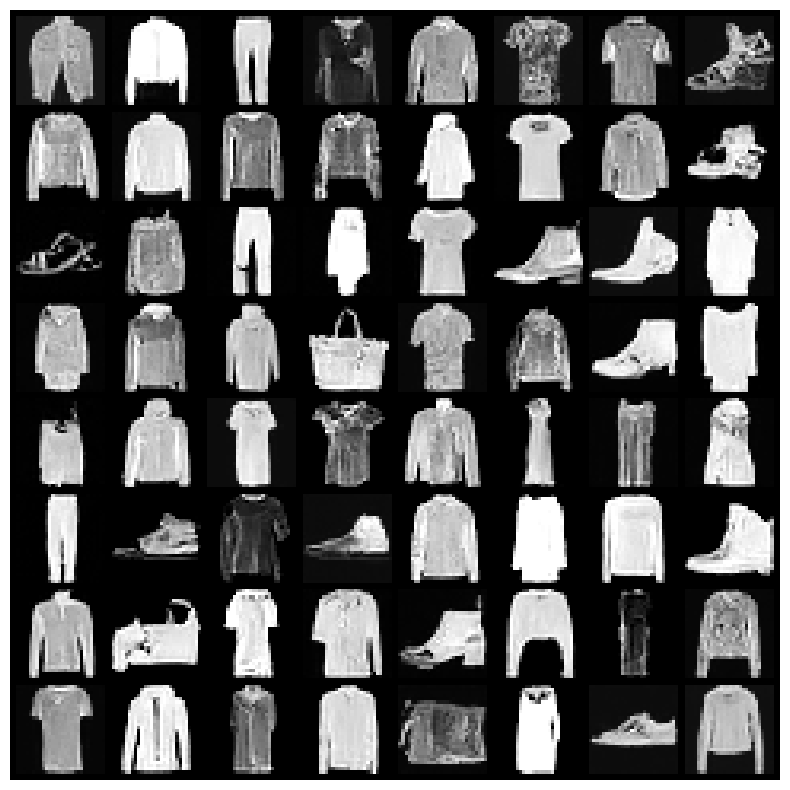

In [ ]:
# Visualize samples
plt.figure(figsize=(10, 10))
grid = make_grid(samples.cpu(), nrow=8, normalize=True)
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.show()